In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import numpy as np
import json
from scipy import stats
import plotly
from plotly.graph_objs import Scatter, Layout

In [44]:
df = pd.read_csv('2008.csv') #Carga el CSV entero
#df # df por data frame es la estructura de datos que representa tablas en pandas https://pandas.pydata.org/pandas-docs/stable/dsintro.html

In [4]:
#df[df.WeatherDelay > 0].groupby('OriginCity').Origin.count().sort_values(ascending=False)# Los Aeropuertos con mas delays por mal tiempo
#-
#df[df.WeatherDelay > 0].groupby('Dest').Dest.count().sort_values(ascending=False)# Los Aeropuertos con mas delays por mal tiempo#
#-
#df['Trip'] = df['Origin'] + "->" + df['Dest'] 
#df[df.WeatherDelay > 0].groupby('Trip').Trip.count().sort_values(ascending=False)
#-
#df[df.WeatherDelay > 0].groupby('Month').Month.count()
#df.plot()
#plt.show()
#-

# Por mes

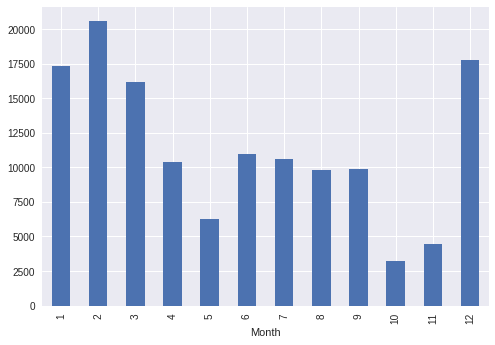

In [81]:
#(df[df.WeatherDelay > 0].groupby('Month').Month.count() / df.groupby('Month').Month.count()).plot.bar()
df[df.Cancelled > 0].groupby('Month').Month.count().plot.bar()
plt.show()

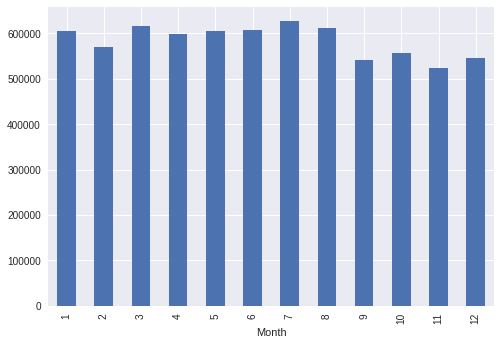

In [13]:
df.groupby('Month').Month.count().plot.bar()
plt.show()

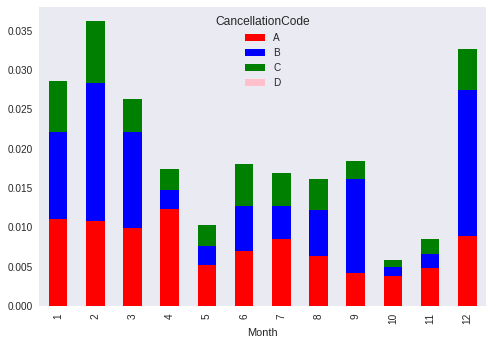

In [28]:
def plotCancellationCodesBy(df, index):  
    # (A = carrier, B = weather, C = NAS, D = security)
    var = df[df.Cancelled > 0].groupby([index,'CancellationCode'])[index].count() / df.groupby([index])[index].count()
    var.unstack().plot(kind='bar',stacked=True, color=['red','blue','green','pink'], grid=False)
    plt.show()
plotCancellationCodesBy(df, 'Month')

# Por Dia

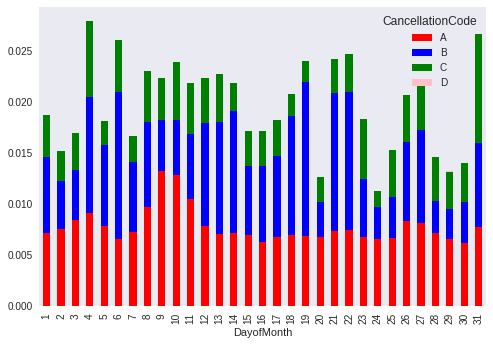

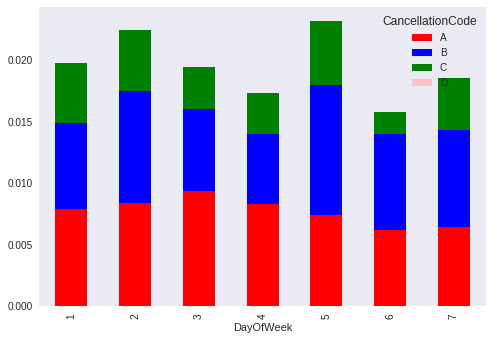

In [107]:
plotCancellationCodesBy(df, 'DayofMonth')
plotCancellationCodesBy(df, 'DayOfWeek')

# Por distancia

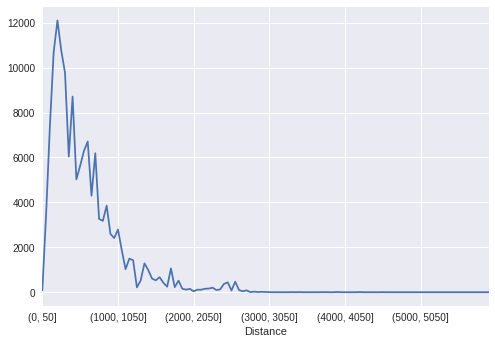

In [85]:
index = 'Distance'
ranges = np.arange(0,6000,50)
#var = df[df.Cancelled > 0].groupby(pd.cut(df[df.Cancelled > 0].Distance, ranges))[index].count() / df.groupby(pd.cut(df.Distance, ranges))[index].count()
var = df[df.Cancelled > 0].groupby(pd.cut(df[df.Cancelled > 0].Distance, ranges))[index].count()
var.plot(kind='line')
plt.show()

# Heatmap


In [45]:
#with open('airportCodeToCityCode.json') as data_file:    
#    airportToCity = json.load(data_file)
def addState(airports, df, code, to):
    for i, row in df.iterrows():
        if airports[airports["Code"] == row[code]].size > 0:
            df.loc[i, to] = airports[airports["Code"] == row[code]].iloc[0].State
    return df
def heatmap(var, statecode, zcode, filename):
    scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

    #HEATMAP
    data = [ dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = var[statecode],
            z = var[zcode].astype(float),
            locationmode = 'USA-states',
            marker = dict(
                line = dict (
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = "Cantidad de Vuelos Demorados en 2008 por mal clima"
            )
        ) ]

    layout = dict(
            title = '2011 US Agriculture Exports by State<br>(Hover for breakdown)',
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showlakes = True,
                lakecolor = 'rgb(255, 255, 255)',
            ),
        )

    fig = dict(data=data, layout=layout)

    url = plotly.offline.plot(fig, filename=filename)


In [46]:
airports = pd.read_csv('airports.csv') 
malClimaSeries = df.groupby('Origin').Origin.count().sort_values(ascending=False)
malClimaDF = pd.DataFrame({'Origin':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Origin', 'OriginState')
var = malClimaDF[malClimaDF.OriginState.notnull()].groupby('OriginState').sum().reset_index()
heatmap(var, 'OriginState', 'Count', 'origen2008.html') 

malClimaSeries = df.groupby('Dest').Dest.count().sort_values(ascending=False)
malClimaDF = pd.DataFrame({'Dest':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Dest', 'DestState')
var = malClimaDF[malClimaDF.DestState.notnull()].groupby('DestState').sum().reset_index()
heatmap(var, 'DestState', 'Count', 'dest2008.html')


malClimaSeries = df[df.Cancelled > 0].groupby('Origin').Origin.count().sort_values(ascending=False)
malClimaDF = pd.DataFrame({'Origin':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Origin', 'OriginState')
var = malClimaDF[malClimaDF.OriginState.notnull()].groupby('OriginState').sum().reset_index()
heatmap(var, 'OriginState', 'Count', 'Cancelledorigen2008.html') 

malClimaSeries = df[df.Cancelled > 0].groupby('Dest').Dest.count().sort_values(ascending=False)
malClimaDF = pd.DataFrame({'Dest':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Dest', 'DestState')
var = malClimaDF[malClimaDF.DestState.notnull()].groupby('DestState').sum().reset_index()
heatmap(var, 'DestState', 'Count', 'Cancelleddest2008.html')
#var = malClimaDF[malClimaDF.OriginState.isnull()]

In [86]:
malClimaSeries = df.groupby('Origin').Origin.count()
malClimaDF = pd.DataFrame({'Origin':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Origin', 'OriginState')

var = malClimaDF[malClimaDF.OriginState.notnull()].groupby('OriginState').sum().reset_index()

malClimaSeries = df[df.Cancelled > 0].groupby('Origin').Origin.count()
malClimaDF = pd.DataFrame({'Origin':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Origin', 'OriginState')

var2 =  malClimaDF[malClimaDF.OriginState.notnull()].groupby('OriginState').sum().reset_index()
for i, row in var2.iterrows():
    var2.loc[i, 'Count'] = row['Count'] / var[var["OriginState"] == row["OriginState"]].iloc[0].Count
heatmap(var2, 'OriginState', 'Count', 'CancelledPorcentajeOrigin2008.html')

In [78]:
a = df.groupby('UniqueCarrier').WeatherDelay.sum() / df.groupby('UniqueCarrier').WeatherDelay.count()
a.sort_values(ascending=False)

UniqueCarrier
OH    12.807839
EV     8.492954
NW     4.002784
MQ     3.669936
9E     3.263802
YV     3.164176
OO     2.910390
XE     2.816085
CO     2.741824
AA     2.568192
WN     2.323771
UA     1.844820
DL     1.690854
AS     1.571083
AQ     1.494924
US     1.228257
B6     1.121874
F9     1.082135
HA     0.869744
FL     0.637104
Name: WeatherDelay, dtype: float64

In [ ]:
malClimaSeries = df.groupby('Origin').Origin.count()
malClimaDF = pd.DataFrame({'Origin':malClimaSeries.index, 'Count':malClimaSeries.values})
malClimaDF = addState(airports, malClimaDF, 'Origin', 'OriginState')
malClimaDF[malClimaDF['OriginState'] == "IA"]